## Neural Network

Traing NN as save to file

C:\Users\Prezes\AppData\Local\Temp\ipykernel_19228\1791530728.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Zespół_1'] = label_encoder.fit_transform(features['Zespół_1'])
C:\Users\Prezes\AppData\Local\Temp\ipykernel_19228\1791530728.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Zespół_2'] = label_encoder.transform(features['Zespół_2'])


Epoch 1/30


25/25 [==============================] - 1s 10ms/step - loss: 1.7602 - accuracy: 0.4775 - val_loss: 1.5149 - val_accuracy: 0.5373
Epoch 2/30
25/25 [==============================] - 0s 3ms/step - loss: 1.7337 - accuracy: 0.4750 - val_loss: 1.5014 - val_accuracy: 0.5572
Epoch 3/30
25/25 [==============================] - 0s 3ms/step - loss: 1.7503 - accuracy: 0.4975 - val_loss: 1.4900 - val_accuracy: 0.5572
Epoch 4/30
25/25 [==============================] - 0s 3ms/step - loss: 1.7026 - accuracy: 0.5225 - val_loss: 1.4769 - val_accuracy: 0.5672
Epoch 5/30
25/25 [==============================] - 0s 3ms/step - loss: 1.6731 - accuracy: 0.4988 - val_loss: 1.4669 - val_accuracy: 0.5721
Epoch 6/30
25/25 [==============================] - 0s 3ms/step - loss: 1.6333 - accuracy: 0.5013 - val_loss: 1.4577 - val_accuracy: 0.5821
Epoch 7/30
25/25 [==============================] - 0s 3ms/step - loss: 1.6736 - accuracy: 0.5025 - val_loss: 1.4502 - val_accuracy: 0.5672
Epoch 8/30
25/25 

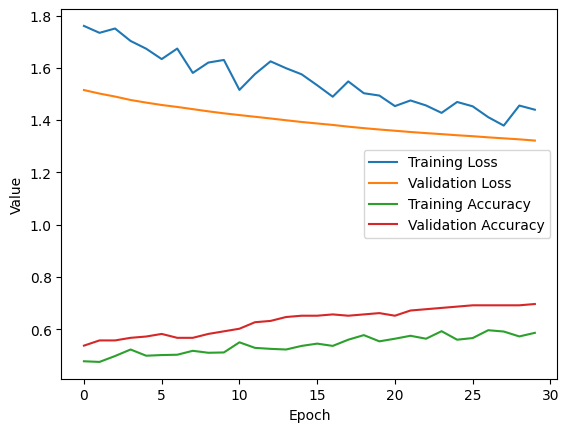

c:\Users\Prezes\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['scaler_labels.joblib']

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import joblib

data = pd.read_csv('2024-01-26-filled.csv')

features = data[['Zespół_1', 'Zespół_2', '1', '0', '2', '10', '02', '12']]
labels = data[['Bramki_1', 'Bramki_2']]

label_encoder = LabelEncoder()
features['Zespół_1'] = label_encoder.fit_transform(features['Zespół_1'])
features['Zespół_2'] = label_encoder.transform(features['Zespół_2'])

features = features.fillna(features.mean())
labels = labels.fillna(labels.mean())

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
input_dim = X_train.shape[1]

label_encoder_zespol_2 = LabelEncoder()

X_test['Zespół_2'] = label_encoder_zespol_2.fit_transform(X_test['Zespół_2'])

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

scaler_labels = StandardScaler()
y_train = scaler_labels.fit_transform(y_train)
y_test = scaler_labels.transform(y_test)

model = Sequential([
    Dense(32, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(2, activation='linear') # As output we have goal for 1st and 2nd club
])

opt = Adam(learning_rate=0.0001)

model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Narysuj wykres wyników straty od epok
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

model.save('model.h5')
joblib.dump(label_encoder, 'label_encoder.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(scaler_labels, 'scaler_labels.joblib')

Data auto-test

In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import load_model
import joblib
import numpy as np

model = load_model('model.h5')
label_encoder = joblib.load('label_encoder.joblib')
scaler = joblib.load('scaler.joblib')
scaler_labels = joblib.load('scaler_labels.joblib')
data = pd.read_csv('2024-01-26-filled.csv')

data_subset = data.iloc[780:-8, :]

data_subset['Zespół_1'] = label_encoder.transform(data_subset['Zespół_1'])
data_subset['Zespół_2'] = label_encoder.transform(data_subset['Zespół_2'])

# Filter dana for range 1-2 in bet type '1'
data_subset_filtered = data_subset[(data_subset['1'] >= 1) & (data_subset['1'] <= 2)]

input_data_scaled = scaler.transform(data_subset_filtered[['Zespół_1', 'Zespół_2', '1', '0', '2', '10', '02', '12']])

prediction_scaled = model.predict(input_data_scaled)

prediction = scaler_labels.inverse_transform(prediction_scaled)

data_subset_filtered['Predicted_Winner'] = 0  # draw by default

data_subset_filtered.loc[(prediction[:, 0] - prediction[:, 1]) > 0.7, 'Predicted_Winner'] = 1
data_subset_filtered.loc[(prediction[:, 0] - prediction[:, 1]) < -0.7, 'Predicted_Winner'] = 2
data_subset_filtered['Goal_Difference'] = np.round((prediction[:, 0] - prediction[:, 1]), 2)

data_subset_filtered['Zespół_1'] = label_encoder.inverse_transform(data_subset_filtered['Zespół_1'])
data_subset_filtered['Zespół_2'] = label_encoder.inverse_transform(data_subset_filtered['Zespół_2'])


print(data_subset_filtered[['Zespół_1', 'Zespół_2', '1', 'Wygrany', 'Predicted_Winner', 'Goal_Difference']])


3/3 [==============================] - 0s 2ms/step
               Zespół_1         Zespół_2     1  Wygrany  Predicted_Winner  \
784               Mainz       Heidenheim  1.66      2.0                 0   
787             Leipzig       Hoffenheim  1.36      1.0                 1   
788           Newcastle           Fulham  1.84      1.0                 0   
789             Chelsea   Sheffield Utd.  1.19      1.0                 1   
790         Bournemouth       Luton Town  1.47      0.0                 1   
..                  ...              ...   ...      ...               ...   
982             Real M.          Almeria  1.15      1.0                 1   
984              Girona       FC Sevilla  1.72      1.0                 0   
988                Ajax         Waalwijk  1.24      1.0                 1   
991  Vitoria Guimarares  Estrela Amadora  1.61      1.0                 0   
992            Brighton    Wolverhampton  1.65      0.0                 1   

     Goal_Difference  
7

C:\Users\Prezes\AppData\Local\Temp\ipykernel_19228\2565119595.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['Zespół_1'] = label_encoder.transform(data_subset['Zespół_1'])
C:\Users\Prezes\AppData\Local\Temp\ipykernel_19228\2565119595.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['Zespół_2'] = label_encoder.transform(data_subset['Zespół_2'])
C:\Users\Prezes\AppData\Local\Temp\ipykernel_19228\2565119595.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy 

Manual test

In [12]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import load_model
import joblib

model = load_model('model.h5')
label_encoder = joblib.load('label_encoder.joblib')
scaler = joblib.load('scaler.joblib')
scaler_labels = joblib.load('scaler_labels.joblib')

input_data = pd.DataFrame({
    'Zespół_1': ['Man.City'],
    'Zespół_2': ['Sheffield Utd.'],
    '1': [1.19],
    '0': [7.6],
    '2': [12],
    '10': [1.04],
    '02': [4.75],
    '12': [1.09]
})

input_data['Zespół_1'] = label_encoder.transform(input_data['Zespół_1'])
input_data['Zespół_2'] = label_encoder.transform(input_data['Zespół_2'])

input_data_scaled = scaler.transform(input_data[['Zespół_1', 'Zespół_2', '1', '0', '2', '10', '02', '12']])

prediction_scaled = model.predict(input_data_scaled)

prediction = scaler_labels.inverse_transform(prediction_scaled)

print(f"Predicted score {input_data['Zespół_1'].values[0]} vs {input_data['Zespół_2'].values[0]}:")
print(f"Goals_1: {prediction[0, 0]}")
print(f"Goals_2: {prediction[0, 1]}")

1/1 [==============================] - 0s 55ms/step
Predicted score 92 vs 126:
Goals_1: 1.969693899154663
Goals_2: 1.2131049633026123
